# Data Analysis and Jaccard Duck Score

In [1]:
import torch
import pickle
from pathlib import Path
import requests
import json
from xml.dom import minidom
from tqdm import tqdm
import time
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [2]:
plt.style.use('seaborn')
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize'] = 'medium'
plt.rcParams['ytick.labelsize'] = 'medium'

## Loading data

In [3]:
with open("/fsx/matzeni/data/entity_to_properties.pkl", "rb") as f:
    entity_to_properties = pickle.load(f)

with open("/fsx/matzeni/data/property_ids_to_labels.pkl", "rb") as f:
    property_ids_to_labels = pickle.load(f)

In [4]:
label_to_property_id = {v: k for k, v in property_ids_to_labels.items()}

In [5]:
wikipedia_to_wikidata_path = Path("/fsx/matzeni/data/en_title2wikidataID.pkl")
with open(wikipedia_to_wikidata_path, "rb") as f:
    wikipedia_to_wikidata = pickle.load(f)

In [6]:
wikidata_to_wikipedia = {
    wid: title
    for title, wids in wikipedia_to_wikidata.items()
    for wid in wids
}

In [7]:
def read_entities():
    ned_dataset_paths = list(Path("/fsx/matzeni/WNED/wned-datasets/").rglob("*.xml"))
    entities = []
    for dataset_path in ned_dataset_paths:
        dom = minidom.parse(str(dataset_path))
        current_entities = [
            element.childNodes[0].nodeValue for element in dom.getElementsByTagName("wikiName")
            if len(element.childNodes) > 0
        ]
        current_entities = [e.strip() for e in current_entities if e is not None and e.strip() != ""]
        entities += current_entities
    return entities

In [8]:
def resolve_mention(mention):
    if mention not in wikipedia_to_wikidata:
        return None
    wids = wikipedia_to_wikidata[mention]
    if len(wids) == 1:
        return list(wids)[0]
    for wid in wids:
        if wid in entity_to_properties:
            return wid
    return None

In [9]:
def readable_properties(wid):
    pids = entity_to_properties[wid]
    return [property_ids_to_labels[pid] for pid in pids]

In [10]:
all_entities = list(set(read_entities()))

## Distribution of properties and entities

In [11]:
print(f"Numer of entites: {len(all_entities)}")

Numer of entites: 14864


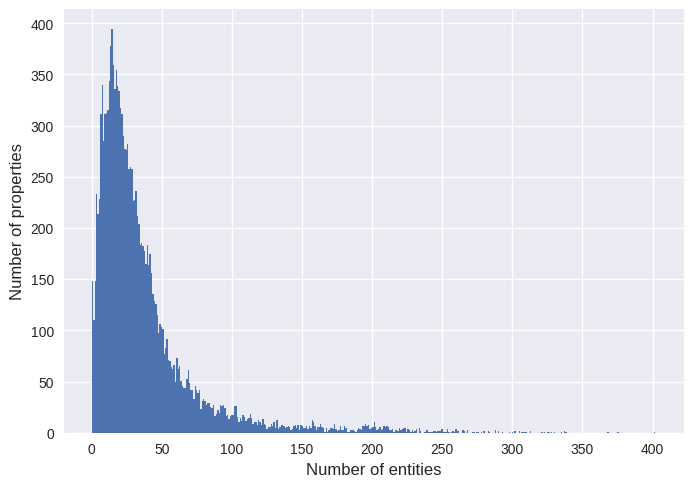

In [12]:
num_properties = [len(properties) for e, properties in entity_to_properties.items()]
num_properties = np.array(num_properties)
plt.hist(num_properties, bins=400)
plt.xlabel("Number of entities")
plt.ylabel("Number of properties")
plt.show()

In [13]:
noprops = sum(num_properties == 0)
print(f"Entities with no properties: {noprops} out of {len(all_entities)} ({noprops / len(all_entities):.4f})")
print()
avg_props = sum(num_properties) / len(num_properties)
print(f"Avergage number of properties per entity: {avg_props:.2f}")

Entities with no properties: 33 out of 14864 (0.0022)

Avergage number of properties per entity: 38.01


In [14]:
all_properties = {p for pids in entity_to_properties.values() for p in pids}
property_to_entities = {p: set() for p in all_properties}
for e, pids in entity_to_properties.items():
    for pid in pids:
        property_to_entities[pid].add(e)

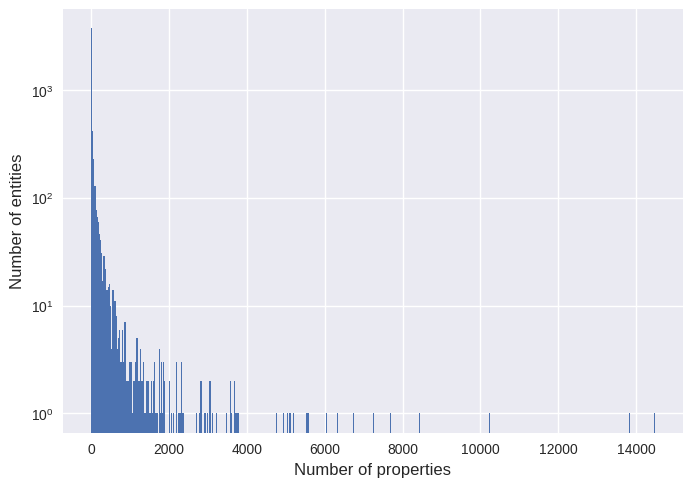

In [15]:
num_entities = [len(ents) for ents in property_to_entities.values()]
num_entities = np.array(num_entities)
plt.hist(num_entities, bins=500)
plt.yscale("log")
plt.xlabel("Number of properties")
plt.ylabel("Number of entities")
plt.show()

## Most frequent properties

In [16]:
property_to_num_entities = {
    p: len(ents)
    for p, ents in sorted(property_to_entities.items(), key=lambda x: len(x[1]), reverse=True)
}
[(property_ids_to_labels[p], count) for p, count in property_to_num_entities.items()][:20]

[('Freebase ID', 14474),
 ('instance of', 13809),
 ('Commons category', 10229),
 ('image', 8428),
 ("topic's main category", 7680),
 ('country', 7259),
 ('Library of Congress authority ID', 6733),
 ('VIAF ID', 6312),
 ('official website', 6033),
 ('WorldCat Identities ID', 5562),
 ('Quora topic ID', 5548),
 ('inception', 5198),
 ('National Library of Israel J9U ID', 5096),
 ('GND ID', 5054),
 ('Encyclopædia Britannica Online ID', 4929),
 ('sport', 4750),
 ('sex or gender', 3767),
 ('coordinate location', 3749),
 ('occupation', 3729),
 ('date of birth', 3704)]

In [17]:
stop_properties = list(property_to_num_entities.keys())[:15]
print("\n".join(property_ids_to_labels[p] for p in stop_properties))
stop_properties = set(stop_properties)

Freebase ID
instance of
Commons category
image
topic's main category
country
Library of Congress authority ID
VIAF ID
official website
WorldCat Identities ID
Quora topic ID
inception
National Library of Israel J9U ID
GND ID
Encyclopædia Britannica Online ID


In [18]:
def get_properties_from_wikipedia(title, stop_properties=[]):
    if title not in wikipedia_to_wikidata:
        return []
    wids = wikipedia_to_wikidata[title]
    return [p for wid in wids for p in entity_to_properties[wid] if p not in stop_properties]

wikipedia_to_properties = {
    e: get_properties_from_wikipedia(e, stop_properties=stop_properties)
    for e in all_entities
}

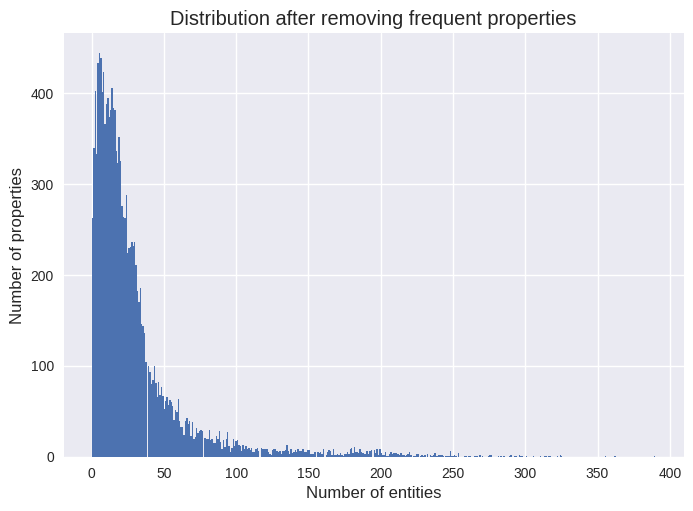

In [19]:
num_properties = [len(properties) for e, properties in wikipedia_to_properties.items()]
num_properties = np.array(num_properties)
plt.hist(num_properties, bins=400)
plt.xlabel("Number of entities")
plt.ylabel("Number of properties")
plt.title("Distribution after removing frequent properties")
plt.show()

In [20]:
noprops = sum(num_properties == 0)
print(f"Entities with no properties: {noprops} out of {len(all_entities)} ({noprops / len(all_entities):.4f})")

Entities with no properties: 263 out of 14864 (0.0177)


# Duck similarity (Jaccard)

In [21]:
min_support = 3

In [22]:
coverage = 1 - (sum(num_properties < min_support) / len(all_entities))
print(f"Coverage: {coverage}")

Coverage: 0.9323196986006459


In [23]:
def duck_similarity(e1, e2, min_support=3):
    r1 = set(wikipedia_to_properties[e1])
    r2 = set(wikipedia_to_properties[e2])
    if len(r1) < min_support and len(r2) < min_support:
        return 0
    return len(r1 & r2) / len(r1 | r2)

In [24]:
duck_similarities = {}
for i, e1 in tqdm(enumerate(all_entities), total=len(all_entities)):
    for j in range(i + 1, len(all_entities)):
        e2 = all_entities[j]
        duck_similarities[(e1, e2)] = duck_similarity(e1, e2, min_support=min_support)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14864/14864 [25:11<00:00,  9.83it/s]


In [25]:
df = pd.DataFrame(
    ((k[0], k[1], v)
    for k, v in tqdm(duck_similarities.items())),
    columns=["e1", "e2", "duck_score"]
)
df = df.sort_values(by="duck_score", ascending=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110461816/110461816 [02:04<00:00, 885583.09it/s]


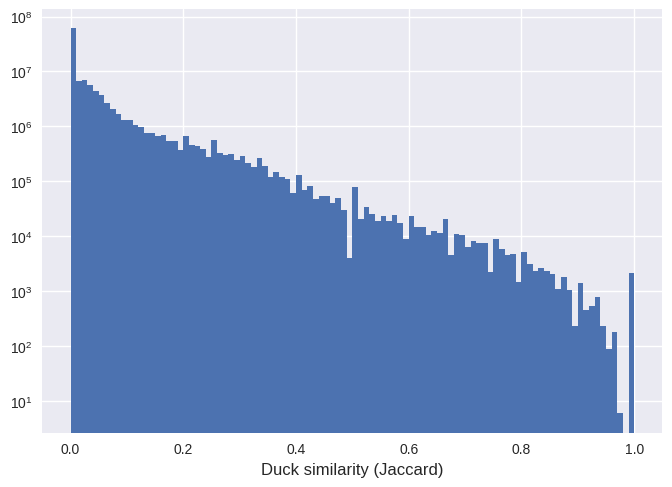

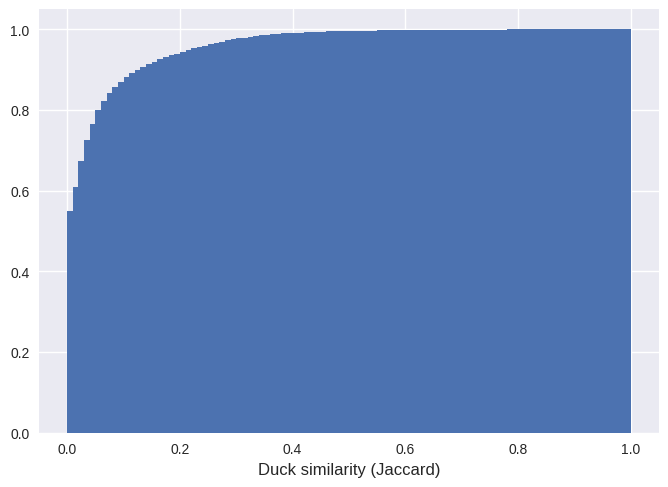

In [62]:
plt.hist(df['duck_score'], bins=100)
plt.yscale('log')
plt.xlabel('Duck similarity (Jaccard)')
plt.show()

plt.hist(df['duck_score'], bins=100, cumulative=True, density=True)
plt.xlabel('Duck similarity (Jaccard)')
plt.show()

In [65]:
df.head(100000).tail(50)

,e1,e2,duck_score
83077105,London Borough of Harrow,London Borough of Hammersmith and Fulham,0.686275
65918318,Thailand,Cuba,0.686275
30914690,Philippines,Slovenia,0.686275
68969076,Hastings,Worthing,0.686275
75890249,Sertraline,Eflornithine,0.686275
52849376,"Okaloosa County, Florida","Palm Beach County, Florida",0.686275
54450623,"Bowling Green, Kentucky","Knoxville, Tennessee",0.686275
60148625,Angola,Egypt,0.686275
46424101,Senegal,Algeria,0.686275
65926421,Cambodia,Republic of the Congo,0.686275


In [63]:
duck_similarity('United Kingdom', 'Italy')

0.6310975609756098

In [30]:
duck_sim_path = Path(f"/fsx/matzeni/data/duck_jaccard_support{min_support}.pkl")
with open(duck_sim_path, "wb") as f:
    pickle.dump(duck_similarities, f)